In [1]:
import numpy as np
import pandas as pd
from keras import models
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


Using TensorFlow backend.


Next, we can initialize the random number generator to ensure that we always get the same results when executing this code. This will help if we are debugging:

In [2]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


Now we can load the dataset using pandas and split the columns into 60 input variables (x) and 1 output variable (y. We use pandas to load the data because it easily handles strings (the output variable), whereas attempting to load the data directly using NumPy would be more difficult.

In [3]:
# load dataset
dataframe = pd.read_csv("sonar.csv", header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
x = dataset[:,0:60].astype(float)
y = dataset[:,60]


The output variable is string values. We must convert them into integer values 0 and 1.

We can do this using the LabelEncoder class from scikit-learn. This class will model the encoding required using the entire dataset via the fit() function, then apply the encoding to create a new output variable using the transform() function.




In [4]:
#converting label to numbers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(np.unique(y))
print(le.classes_)
y_encoded = le.transform(y)
y_encoded

['M' 'R']


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

We can use scikit-learn to evaluate the model using stratified k-fold cross validation. This is a resampling technique that will provide an estimate of the performance of the model. It does this by splitting the data into k-parts, training the model on all parts except one which is held out as a test set to evaluate the performance of the model. This process is repeated k-times and the average score across all constructed models is used as a robust estimate of performance. It is stratified, meaning that it will look at the output values and attempt to balance the number of instances that belong to each class in the k-splits of the data.

To use Keras models with scikit-learn, we must use the KerasClassifier wrapper. This class takes a function that creates and returns our neural network model. It also takes arguments that it will pass along to the call to fit() such as the number of epochs and the batch size.

Let’s start off by defining the function that creates our baseline model. Our model will have a single fully connected hidden layer with the same number of neurons as input variables. This is a good default starting point when creating neural networks.

The weights are initialized using a small Gaussian random number. The Rectifier activation function is used. The output layer contains a single neuron in order to make predictions. It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1 that can easily and automatically be converted to crisp class values.

Finally, we are using the logarithmic loss function (binary_crossentropy) during training, the preferred loss function for binary classification problems. The model also uses the efficient Adam optimization algorithm for gradient descent and accuracy metrics will be collected when the model is trained.

In [56]:
# baseline model
def create_baseline():
  model = models.Sequential()
  model.add(layers.Dense(60,activation = 'relu',input_shape =(x[1].shape))) #input shape need to be vector so here its (60, )
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model


Now it is time to evaluate this model using stratified cross validation in the scikit-learn framework.

We pass the number of training epochs to the KerasClassifier, again using reasonable default values. Verbose output is also turned off given that the model will be created 10 times for the 10-fold cross validation being performed.


In [11]:
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, x, y_encoded, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Results: 83.71% (6.13%)


# Step 3. Re-Run The Baseline Model With Data Preparation
It is a good practice to prepare your data before modeling.

Neural network models are especially suitable to having consistent input values, both in scale and distribution.

An effective data preparation scheme for tabular data when building neural network models is standardization. This is where the data is rescaled such that the mean value for each attribute is 0 and the standard deviation is 1. This preserves Gaussian and Gaussian-like distributions whilst normalizing the central tendencies for each attribute.

We can use scikit-learn to perform the standardization of our Sonar dataset using the StandardScaler class:
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html 

Rather than performing the standardization on the entire dataset, it is good practice to train the standardization procedure on the training data within the pass of a cross-validation run and to use the trained standardization to prepare the “unseen” test fold. This makes standardization a step in model preparation in the cross-validation process and it prevents the algorithm having knowledge of “unseen” data during evaluation, knowledge that might be passed from the data preparation scheme like a crisper distribution.

We can achieve this in scikit-learn using a Pipeline:
http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html 

The pipeline is a wrapper that executes one or more models within a pass of the cross-validation procedure. Here, we can define a pipeline with the StandardScaler followed by our neural network model.



In [12]:
# evaluate baseline model with standardized dataset
np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, x, y_encoded, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Standardized: 85.59% (7.46%)


# Step 4. Tuning Layers and Number of Neurons in The Model
There are many things to tune on a neural network, such as the weight initialization, activation functions, optimization procedure and so on.

One aspect that may have an outsized effect is the structure of the network itself called the network topology. In this section, we take a look at two experiments on the structure of the network: making it smaller and making it larger.

These are good experiments to perform when tuning a neural network on your problem.


## 4.1. Evaluate a Smaller Network
We suspect that there is a lot of redundancy in the input variables for this project.

The data describes the same signal from different angles. Perhaps some of those angles are more relevant than others. We can force a type of feature extraction by the network by restricting the representational space in the first hidden layer.

In this experiment, we take our baseline model with 60 neurons in the hidden layer and reduce it by half to 30. This will put pressure on the network during training to pick out the most important structure in the input data to model.

We will also standardize the data as in the previous experiment with data preparation and try to take advantage of the small lift in performance.


In [13]:
# smaller model
np.random.seed(seed)
def create_smaller():
  model = models.Sequential()
  model.add(layers.Dense(30,activation = 'relu',input_shape =(x[1].shape)))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
  	
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_smaller, epochs=20, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, x, y_encoded, cv=kfold)
print("Smaller: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Smaller: 83.52% (8.42%)


## Step 4.2. Evaluate a Larger Network
A neural network topology with more layers offers more opportunity for the network to extract key features and recombine them in useful nonlinear ways.

We can evaluate whether adding more layers to the network improves the performance easily by making another small tweak to the function used to create our model. Here, we add one new layer (one line) to the network that introduces another hidden layer with 30 neurons after the first hidden layer.

Our network now has the topology:

60 inputs -> [60 -> 30] -> 1 output

The idea here is that the network is given the opportunity to model all input variables before being bottlenecked and forced to halve the representational capacity, much like we did in the experiment above with the smaller network.

Instead of squeezing the representation of the inputs themselves, we have an additional hidden layer to aid in the process.


In [14]:
# larger model
np.random.seed(seed)

def create_larger():
  model = models.Sequential()
  model.add(layers.Dense(60,activation = 'relu',input_shape =(x[1].shape)))
  model.add(layers.Dense(30,activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_larger, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, x, y_encoded, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Larger: 84.61% (6.36%)


# Step 5: Really Scaling up: 
developing a model that overfits
Once you’ve obtained a model that has statistical power, the question becomes, is your
model sufficiently powerful? Does it have enough layers and parameters to properly
model the problem at hand? 

Remember that the universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it.

To figure out how big a model you’ll need, you must develop a model that overfits.
This is fairly easy:
1.	Add layers.
2.	Make the layers bigger.
3.	Train for more epochs.

Always monitor the training loss and validation loss, as well as the training and validation values for any metrics you care about. When you see that the model’s performance on the validation data begins to degrade, you’ve achieved overfitting.


In [8]:
seed = 7
np.random.seed(seed)

def create_larger():
  model = models.Sequential()
  model.add(layers.Dense(100,activation = 'relu',input_shape =(x[1].shape)))
  model.add(layers.Dense(50,activation = 'relu'))
  model.add(layers.Dense(25,activation = 'relu'))
  model.add(layers.Dense(6, activation = 'relu',))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_larger, epochs=150, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, x, y_encoded, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 87.47% (6.58%)


In [17]:
# with 200 epochs
np.random.seed(seed)

def create_larger_1():
  model = models.Sequential()
  model.add(layers.Dense(100,activation = 'relu',input_shape =(x[1].shape)))
  model.add(layers.Dense(50,activation = 'relu'))
  model.add(layers.Dense(25,activation = 'relu'))
  model.add(layers.Dense(6, activation = 'relu',))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_larger_1, epochs=200, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, x, y_encoded, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 87.38% (8.12%)


Since the performance has started to decrease so we will use the model with 87.95%

The next step is to start regularizing and tuning the model, to get as close as possible to the ideal model that neither underfits nor overfits.

# Step 6: Tuning the Model
With further tuning of aspects like the optimization algorithm etc. and the number of training epochs, it is expected that further improvements are possible. What is the best score that you can achieve on this dataset?


In [18]:
# with rmsprop optimizer
np.random.seed(seed)

def model_v1():
  model = models.Sequential()
  model.add(layers.Dense(100,activation = 'relu',input_shape =(x[1].shape)))
  model.add(layers.Dense(50,activation = 'relu'))
  model.add(layers.Dense(25,activation = 'relu'))
  model.add(layers.Dense(6, activation = 'relu',))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'rmsprop',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=model_v1, epochs=150, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, x, y_encoded, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 87.47% (5.85%)


In [19]:
# with adam optimizer and wieght dropout of 20%
np.random.seed(seed)

def model_v2():
  model = models.Sequential()
  model.add(layers.Dense(100,activation = 'relu',input_shape =(x[1].shape)))
  model.add(layers.Dropout(0.20))
  model.add(layers.Dense(50,activation = 'relu'))
  model.add(layers.Dropout(0.20))
  model.add(layers.Dense(25,activation = 'relu'))
  model.add(layers.Dropout(0.20))
  model.add(layers.Dense(6, activation = 'relu',))
  model.add(layers.Dropout(0.20))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=model_v2, epochs=150, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, x, y_encoded, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 84.07% (5.45%)
Larger: 84.07% (5.45%)


In [20]:
# with adam optimizer and wieght dropout of 50%
np.random.seed(seed)

def model_v3():
  model = models.Sequential()
  model.add(layers.Dense(100,activation = 'relu',input_shape =(x[1].shape)))
  model.add(layers.Dropout(0.50))
  model.add(layers.Dense(50,activation = 'relu'))
  model.add(layers.Dropout(0.50))
  model.add(layers.Dense(25,activation = 'relu'))
  model.add(layers.Dropout(0.50))
  model.add(layers.Dense(6, activation = 'relu',))
  model.add(layers.Dropout(0.50))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=model_v3, epochs=150, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, x, y_encoded, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 82.18% (8.12%)


So dropping weights do not produce good results lets try weight regularization

In [22]:
# with L2 weight regularizer 
from keras import regularizers
np.random.seed(seed)

def model_v4():
  model = models.Sequential()
  model.add(layers.Dense(100,activation = 'relu',kernel_regularizer = regularizers.l2(0.001),input_shape =(x[1].shape)))
  model.add(layers.Dense(50,activation = 'relu',kernel_regularizer = regularizers.l2(0.001)))
  model.add(layers.Dense(25,activation = 'relu',kernel_regularizer = regularizers.l2(0.001)))
  model.add(layers.Dense(6, activation = 'relu',kernel_regularizer = regularizers.l2(0.001)))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=model_v4, epochs=150, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, x, y_encoded, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 85.99% (6.44%)


In [23]:
# with L1 weight regularizer 
from keras import regularizers
np.random.seed(seed)

def model_v5():
  model = models.Sequential()
  model.add(layers.Dense(100,activation = 'relu',kernel_regularizer = regularizers.l1(0.001),input_shape =(x[1].shape)))
  model.add(layers.Dense(50,activation = 'relu',kernel_regularizer = regularizers.l1(0.001)))
  model.add(layers.Dense(25,activation = 'relu',kernel_regularizer = regularizers.l1(0.001)))
  model.add(layers.Dense(6, activation = 'relu',kernel_regularizer = regularizers.l1(0.001)))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=model_v5, epochs=150, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, x, y_encoded, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 83.16% (5.80%)


Using weight regularizers also do not produce good results

In [6]:
# changing batch size to 1

np.random.seed(seed)

def model_v6():
  model = models.Sequential()
  model.add(layers.Dense(100,activation = 'relu',input_shape =(x[1].shape)))
  model.add(layers.Dense(50,activation = 'relu'))
  model.add(layers.Dense(25,activation = 'relu',))
  model.add(layers.Dense(6, activation = 'relu'))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=model_v6, epochs=150, batch_size=1, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, x, y_encoded, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 87.45% (5.03%)


In [7]:
# Using the previous model
seed = 7
np.random.seed(seed)

def create_larger():
  model = models.Sequential()
  model.add(layers.Dense(100,activation = 'relu',input_shape =(x[1].shape)))
  model.add(layers.Dense(50,activation = 'relu'))
  model.add(layers.Dense(25,activation = 'relu'))
  model.add(layers.Dense(6, activation = 'relu',))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_larger, epochs=150, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, x, y_encoded, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 88.90% (6.56%)


# Step 7: Rewriting the code using the Keras Functional API
Review the April 9, 2018 presentation done by Chollet contained in the project file: 

Francois_Chollet_March9.pdf

Now rewrite the code that you have written so far using the Keras Sequential API in Kearas Functional API.


In [10]:
import keras

seed = 7
np.random.seed(seed)
def create_model():
  
  inputs = keras.Input(shape=x[1].shape)
  x_1 = layers.Dense(100, activation = 'relu')(inputs)
  x_2 = layers.Dense(50, activation = 'relu')(x_1)
  x_3 = layers.Dense(25, activation = 'relu')(x_2)
  x_4 = layers.Dense(6, activation = 'relu')(x_3)
  outputs = layers.Dense(1, activation='sigmoid')(x_4)
  model = keras.Model(inputs, outputs)
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model


estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=150, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, x, y_encoded, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Larger: 88.42% (6.60%)


# Step 8: Rewriting the code by doing Model Subclassing
Now rewrite the code that you have written so far using the Keras Model Subclassing as mentioned in the Chollet April 9, 2018 presentation.

Reference:
https://www.tensorflow.org/api_docs/python/tf/keras/Model
Please note you will have to use TensorFlow 1.7+ with built-in Keras. 


In [11]:
seed = 7
np.random.seed(seed)
class MyModel(keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = layers.Dense(100, activation = 'relu')
    
    self.dense2 = layers.Dense(50, activation = 'relu')
    self.dense3 = layers.Dense(25, activation = 'relu')
    self.dense4 = layers.Dense(6, activation = 'relu')
    self.dense5 = layers.Dense(1, activation = 'sigmoid')
    
  def call(self, inputs):
    x_1 = self.dense1(inputs)
    x_2 = self.dense2(x_1)
    x_3 = self.dense3(x_2)
    x_4 = self.dense4(x_3)
    return self.dense5(x_4)
  
def create_model():
  model = MyModel()
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model

estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_model, epochs=150, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(pipeline, x, y_encoded, cv=kfold)
print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
    

Larger: 87.92% (6.95%)


------------------------------------------------------------------------------------------

# Step 9: Rewriting the code without using scikit-learn
Once you have written the model in all three API style you are required to do k-fold cross validation without using scikit-learn library.


In [15]:
np.random.seed(seed)
dataset = dataframe.values
np.random.shuffle(dataset)
# split into input (X) and output (Y) variables
x = dataset[:,0:60].astype(float)
y = dataset[:,60]



In [16]:
y_encoded = []
for value in y:
    if value=='R':
        y_encoded.append(1)
    else:
        y_encoded.append(0)
        
y_encoded = np.asarray(y_encoded)
y_encoded

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0])

In [27]:
np.random.seed(seed)
def create_model():
  model = models.Sequential()
  model.add(layers.Dense(100,activation = 'relu',input_shape =(x[1].shape)))
  model.add(layers.Dense(50,activation = 'relu'))
  model.add(layers.Dense(25,activation = 'relu'))
  model.add(layers.Dense(6, activation = 'relu',))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model

k = 10
num_val_samples = len(x) // k #integer division
print(num_val_samples)
num_epochs = 10
results = []
for i in range(k):
    print("Processing field #", i)
    #prepairing the validation data:data from partition K
    val_data = x[i*num_val_samples:(i+1)*num_val_samples]      
    val_targets = y_encoded[i*num_val_samples:(i+1)*num_val_samples]
    #prepairing training data from all other partitions
    partial_train_data = np.concatenate([
        x[:i*num_val_samples],
        x[(i+1)*num_val_samples:]
    ], axis = 0)
    partial_train_target = np.concatenate([
        y_encoded[:i*num_val_samples],
        y_encoded[(i+1)*num_val_samples:]
    ],axis = 0)
    partial_train_data_mean = partial_train_data.mean(axis = 0)
    partial_train_data_std = partial_train_data.std(axis = 0)
    partial_train_data = (partial_train_data - partial_train_data_mean)/partial_train_data_std
    val_data = (val_data - partial_train_data_mean)/partial_train_data_std
   
    model = create_model()
    model.fit(partial_train_data, 
              partial_train_target,
              epochs = num_epochs, 
              batch_size = 5, verbose = 0)
    results.append(model.evaluate(val_data, val_targets))

20
Processing field # 0
20/20 [==============================] - 1s 71ms/step
Processing field # 1
20/20 [==============================] - 1s 70ms/step
Processing field # 2
20/20 [==============================] - 2s 78ms/step
Processing field # 3
20/20 [==============================] - 1s 74ms/step
Processing field # 4
20/20 [==============================] - 1s 74ms/step
Processing field # 5
20/20 [==============================] - 2s 76ms/step
Processing field # 6
20/20 [==============================] - 2s 83ms/step
Processing field # 7
20/20 [==============================] - 2s 82ms/step
Processing field # 8
20/20 [==============================] - 2s 86ms/step
Processing field # 9
20/20 [==============================] - 2s 121ms/step


In [19]:
model.metrics_names

['loss', 'acc']

In [22]:
acc = []
for result in results:
    acc.append(result[1])
acc = np.asarray(acc)
overall_acc = acc.mean()
overall_acc*100

87.99999952316284

In [55]:
model.metrics_names

['loss', 'acc']

In [23]:
np.random.seed(seed)
def create_model():
  model = models.Sequential()
  model.add(layers.Dense(100,activation = 'relu',input_shape =(x[1].shape)))
  model.add(layers.Dense(50,activation = 'relu'))
  model.add(layers.Dense(25,activation = 'relu'))
  model.add(layers.Dense(6, activation = 'relu',))
  model.add(layers.Dense(1, activation = 'sigmoid'))
  model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'] )
  return model

k = 10
num_val_samples = len(x) // k #integer division
print(num_val_samples)
num_epochs = 200
results = []
loss_values = []
val_loss_values = []
for i in range(k):
    print("Processing field #", i)
    #prepairing the validation data:data from partition K
    val_data = x[i*num_val_samples:(i+1)*num_val_samples]      
    val_targets = y_encoded[i*num_val_samples:(i+1)*num_val_samples]
    #prepairing training data from all other partitions
    partial_train_data = np.concatenate([
        x[:i*num_val_samples],
        x[(i+1)*num_val_samples:]
    ], axis = 0)
    partial_train_target = np.concatenate([
        y_encoded[:i*num_val_samples],
        y_encoded[(i+1)*num_val_samples:]
    ],axis = 0)
    partial_train_data_mean = partial_train_data.mean(axis = 0)
    partial_train_data_std = partial_train_data.std(axis = 0)
    partial_train_data = (partial_train_data - partial_train_data_mean)/partial_train_data_std
    val_data = (val_data - partial_train_data_mean)/partial_train_data_std
   
    model = create_model()
    history = model.fit(partial_train_data, 
              partial_train_target,
              epochs = num_epochs, 
              batch_size = 5, verbose = 0,
              validation_data = (val_data, val_targets))
    history_dict = history.history
    loss_values.append(history_dict['loss'])
    val_loss_values.append(history_dict['val_loss'])

20
Processing field # 0
Processing field # 1
Processing field # 2
Processing field # 3
Processing field # 4
Processing field # 5
Processing field # 6
Processing field # 7
Processing field # 8
Processing field # 9


In [24]:
average_loss_history = [np.mean([x[i] for x in loss_values]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in val_loss_values]) for i in range(num_epochs)]

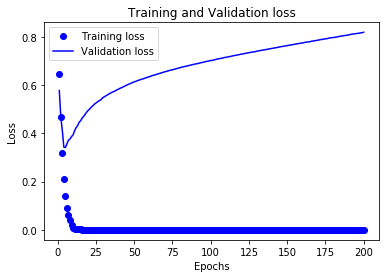

In [26]:
import matplotlib.pyplot as plt
epochs = range(1, len(average_loss_history)+1)
plt.plot(epochs, average_loss_history, 'bo', label = 'Training loss')
plt.plot(epochs, average_val_loss_history, 'b', label = 'Validation loss')
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
